In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 0 = ALL, 1 = WARNING, 2 = ERROR, 3 = FATAL

# Global params

In [2]:
accepted_categories = ["dress", "high_heel", "handbag", "skirt", "outerwear", "boot"]
label2id = {
    "dress": 0,
    "high_heel": 1, 
    "handbag": 2,
    "skirt": 3, 
    "outerwear": 4, 
    "boot": 5
    
}
id2label = {
    0: "dress",
    1: "high_heel", 
    2: "handbag",
    3: "skirt", 
    4: "outerwear", 
    5: "boot"
}

RANDOM_STATE = 12345

# functions

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import random
from PIL import Image

def plot_random_images_per_category(df, image_column='path', category_column='global_category', max_per_row=4):
    """
    Plot one random image per category from the dataframe.

    Parameters:
    - df: pandas.DataFrame with image paths and categories.
    - image_column: str, column name with image file paths.
    - category_column: str, column name with image categories.
    - max_per_row: int, number of images per row in the plot grid.
    """
    categories = df[category_column].unique()
    sampled_rows = df.groupby(category_column).apply(lambda x: x.sample(1)).reset_index(drop=True)

    num_categories = len(categories)
    num_cols = min(max_per_row, num_categories)
    num_rows = (num_categories + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(4 * num_cols, 4 * num_rows))
    axes = axes.flatten() if num_categories > 1 else [axes]

    for ax, (_, row) in zip(axes, sampled_rows.iterrows()):
        try:
            image = Image.open(row[image_column])
            ax.imshow(image)
            ax.set_title(f"{row[category_column]}")
            ax.axis('off')
        except Exception as e:
            ax.text(0.5, 0.5, "Error loading image", ha='center')
            ax.set_title(row[category_column])
            ax.axis('off')
            print(f"Failed to load image at {row[image_column]}: {e}")

    # Hide unused subplots
    for ax in axes[len(sampled_rows):]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()


In [4]:
import pandas as pd

def balance_dataframe_by_class(df, category_column='global_category', samples_per_class=100, random_state=42):
    """
    Returns a balanced dataframe with at most `samples_per_class` samples per category.
    If a category has fewer than the desired amount, all its samples are included.

    Parameters:
    - df (pd.DataFrame): Original DataFrame with category information.
    - category_column (str): Column name to balance by (e.g., 'global_category').
    - samples_per_class (int): Target number of samples per class.
    - random_state (int): Seed for reproducible sampling.

    Returns:
    - pd.DataFrame: Balanced DataFrame.
    """
    balanced_dfs = []

    for category, group in df.groupby(category_column):
        if len(group) <= samples_per_class:
            balanced_dfs.append(group)
        else:
            balanced_dfs.append(group.sample(n=samples_per_class, random_state=random_state))

    balanced_df = pd.concat(balanced_dfs).reset_index(drop=True)
    return balanced_df


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

def plot_top3_predictions(model, val_ds, id2label, rows=3, cols=8):
    """
    Muestra imágenes con las Top-3 predicciones de un modelo, coloreando en verde
    si la etiqueta verdadera está entre ellas, y rojo en caso contrario.

    Parameters:
    - model: modelo Keras o TensorFlow.
    - val_ds: dataset iterable (como tf.data.Dataset).
    - id2label: diccionario {id: nombre_clase}.
    - rows: número de filas a mostrar.
    - cols: número de columnas a mostrar.
    """
    val_images, val_labels = next(iter(val_ds))
    pred_probs = model.predict(val_images)
    
    top3_pred_indices = tf.math.top_k(pred_probs, k=3).indices.numpy()

    fig, axes = plt.subplots(rows, cols, figsize=(20, 10))
    fig.suptitle("Top-3 Predicciones del modelo", fontsize=16)

    for i, ax in enumerate(axes.flat):
        if i >= len(val_images):
            break

        image = val_images[i].numpy()
        true_label = int(val_labels[i].numpy())
        top3_labels = top3_pred_indices[i]

        top3_names = [id2label[idx] for idx in top3_labels]
        pred_text = "\n".join([f"{j+1}: {name}" for j, name in enumerate(top3_names)])

        color = "green" if true_label in top3_labels else "red"

        ax.imshow(image)
        ax.set_title(f"{pred_text}\nT: {id2label[true_label]}", color=color, fontsize=10)
        ax.axis("off")

    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.show()


2025-05-18 18:54:12.406282: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747587252.418161   12605 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747587252.421927   12605 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747587252.435430   12605 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747587252.435444   12605 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747587252.435446   12605 computation_placer.cc:177] computation placer alr

# Loading dataframes

In [6]:
import pandas as pd

train_dataframe = balance_dataframe_by_class(pd.read_csv("conf/train.csv"), samples_per_class=600, random_state=RANDOM_STATE)
validation_dataframe = balance_dataframe_by_class(pd.read_csv("conf/validation.csv"), samples_per_class=100, random_state=RANDOM_STATE)

/tmp/ipykernel_12605/636648337.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_rows = df.groupby(category_column).apply(lambda x: x.sample(1)).reset_index(drop=True)


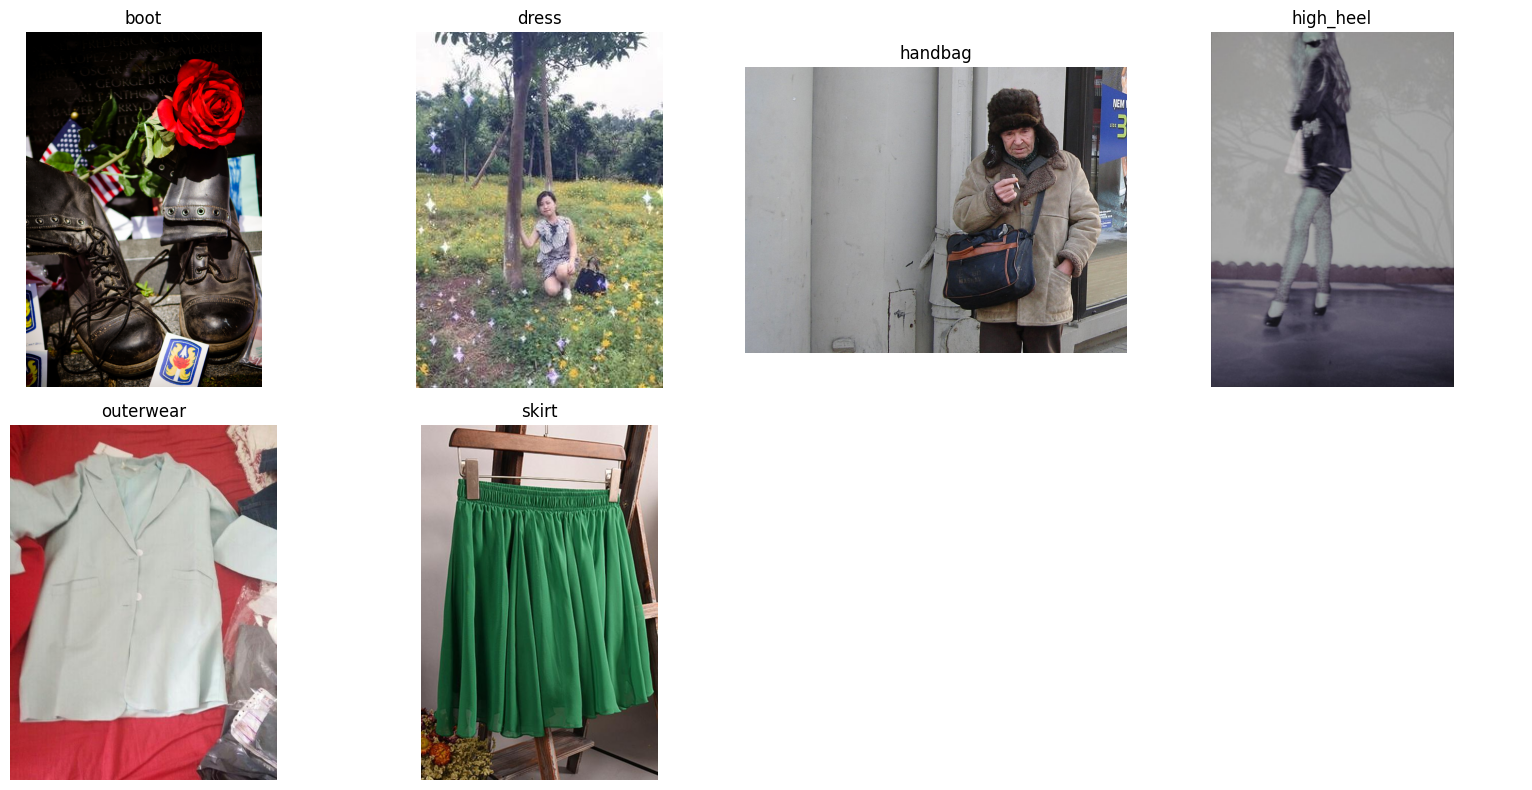

In [7]:
plot_random_images_per_category(train_dataframe)

/tmp/ipykernel_12605/636648337.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_rows = df.groupby(category_column).apply(lambda x: x.sample(1)).reset_index(drop=True)


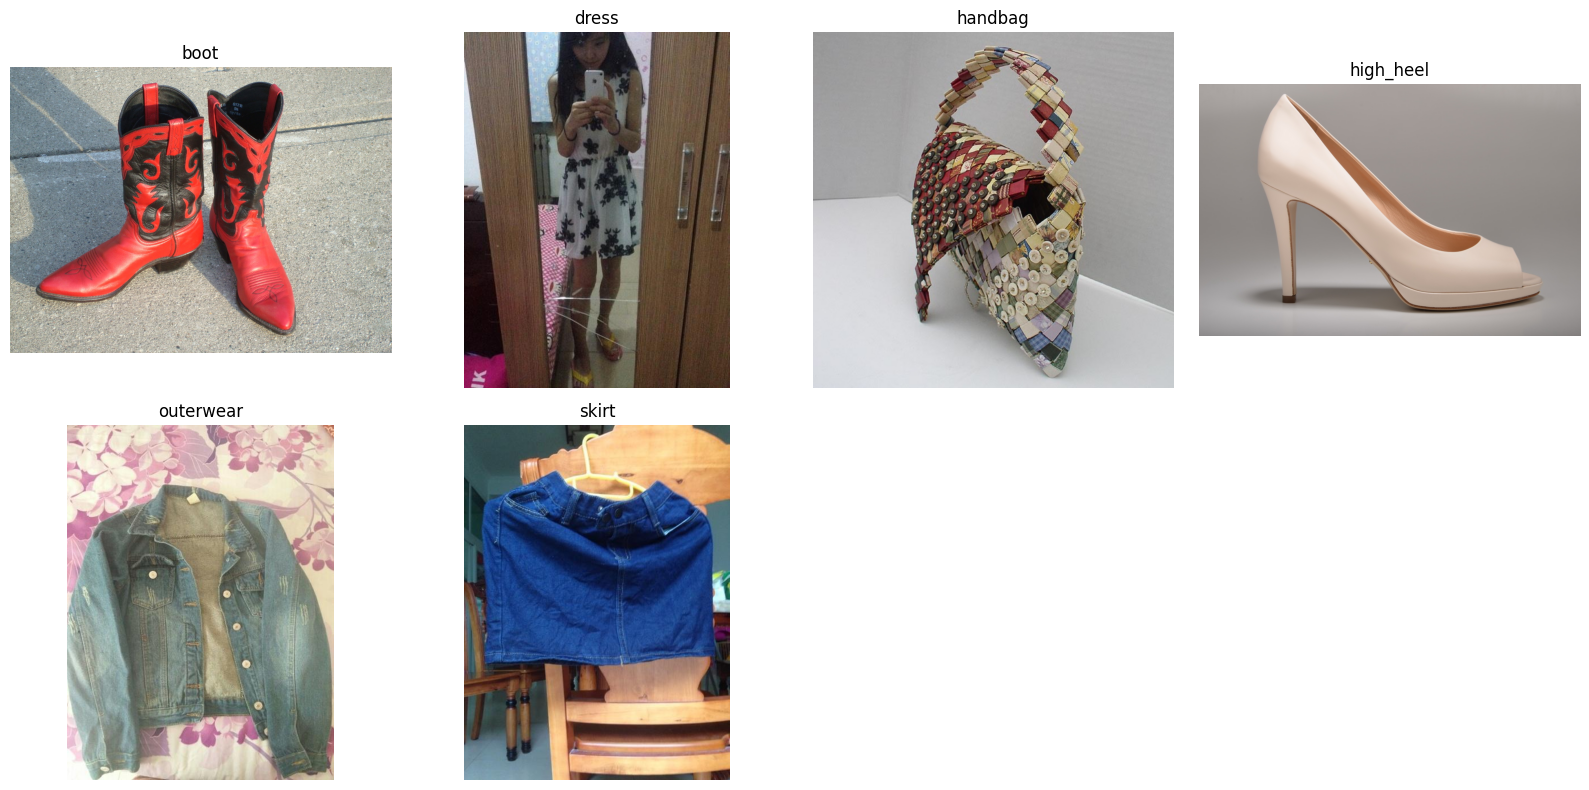

In [8]:
plot_random_images_per_category(validation_dataframe)

In [9]:
train_dataframe.groupby("global_category").size()

global_category
boot         400
dress        600
handbag      400
high_heel    400
outerwear    600
skirt        600
dtype: int64

In [10]:
validation_dataframe.groupby("label_id").size()

label_id
0    100
1    100
2    100
3    100
4    100
5    100
dtype: int64

In [11]:
train_dataframe.head(3)

,path,global_category,label_id
0,../custom_dataset/train/Labeled/Boot/ad595795f...,boot,5
1,../custom_dataset/train/Labeled/Boot/b093b5711...,boot,5
2,../custom_dataset/train/Labeled/Boot/2fb6778de...,boot,5


# General process

# pre-processing

In [12]:
import tensorflow as tf

IMG_SIZE = 248
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

def decode_image(filename, label):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = image / 255.0  # Normalizar
    return image, label

def prepare_dataset(df, shuffle=True):
    paths = df["path"].values
    labels = df["label_id"].values
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(decode_image, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(buffer_size=20_000)  # optimize memory
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    #ds = ds.repeat()
    ds = ds.apply(tf.data.experimental.ignore_errors())
    return ds

train_ds = prepare_dataset(train_dataframe)
val_ds = prepare_dataset(validation_dataframe, shuffle=True)

Instructions for updating:
Use `tf.data.Dataset.ignore_errors` instead.


I0000 00:00:1747587256.647308   12605 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9536 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080 Ti, pci bus id: 0000:0a:00.0, compute capability: 8.6


# Training

In [13]:
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras import layers, models

def sparse_top_k_categorical_accuracy(y_true, y_pred, k=4):
    # Convierte etiquetas de enteros a one-hot para que funcione con top_k
    y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=tf.shape(y_pred)[-1])
    return top_k_categorical_accuracy(y_true, y_pred, k=k)

## Efficient

In [14]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import top_k_categorical_accuracy

# Función de métrica personalizada para sparse top-k
def sparse_top_k_categorical_accuracy(y_true, y_pred, k=4):
    y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=tf.shape(y_pred)[-1])
    return top_k_categorical_accuracy(y_true, y_pred, k=k)

# Definir top-2 y top-3
top_2_accuracy = lambda y_true, y_pred: sparse_top_k_categorical_accuracy(y_true, y_pred, k=2)
top_3_accuracy = lambda y_true, y_pred: sparse_top_k_categorical_accuracy(y_true, y_pred, k=3)

# Cargar base EfficientNetV2B0 con pesos de ImageNet, sin la capa superior
base_model = EfficientNetV2B0(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# Agregar head personalizado
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.2)(x)
output = Dense(len(accepted_categories), activation="softmax")(x)

# Definir modelo completo
model_effnet = Model(inputs=base_model.input, outputs=output)

# Congelar todos los layers
for layer in base_model.layers:
    layer.trainable = False

# Descongelar solo los últimos 15 layers
for layer in base_model.layers[-18:]:
    layer.trainable = True

# Compilar modelo
model_effnet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy", top_2_accuracy, top_3_accuracy]
)


In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from tensorflow.keras.callbacks import TensorBoard
import datetime


checkpoint_cb = ModelCheckpoint(
    filepath='models/efficient_net_tl/best_model.h5',             # O .keras para el nuevo formato
    monitor='val_accuracy',               # Métrica que decides monitorear
    save_best_only=True,                  # Guarda solo el mejor modelo
    mode='max',                           # Porque estás maximizando
    verbose=1
)

log_dir = "logs/fit/efficient_net_tl/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_cb = TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,            # Si quieres histogramas de activaciones
    write_graph=True,            # Guarda el grafo del modelo
    write_images=True            # Guarda imágenes de pesos y outputs (opcional)
)

early_stop_cb = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    mode='min',
    verbose=1
)

In [16]:
history_efficient = model_effnet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=500,
    callbacks=[early_stop_cb,  checkpoint_cb, tensorboard_cb]
)

/home/carlos/miniconda3/envs/deeplearning_kernel/lib/python3.10/site-packages/keras/src/saving/serialization_lib.py:145: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized: top_2_accuracy = lambda y_true, y_pred: sparse_top_k_categorical_accuracy(y_true, y_pred, k=2)

  config_arr = [serialize_keras_object(x) for x in obj]
/home/carlos/miniconda3/envs/deeplearning_kernel/lib/python3.10/site-packages/keras/src/saving/serialization_lib.py:145: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized: top_3_accuracy

Epoch 1/500


I0000 00:00:1747587268.672215   12685 service.cc:152] XLA service 0x7fbf44003000 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747587268.672248   12685 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti, Compute Capability 8.6
I0000 00:00:1747587270.260038   12685 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1747587282.188155   12685 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


     94/Unknown 38s 162ms/step - accuracy: 0.1780 - lambda: 0.3625 - lambda_1: 0.5373 - loss: 1.8069

/home/carlos/miniconda3/envs/deeplearning_kernel/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_accuracy improved from -inf to 0.16333, saving model to models/efficient_net_tl/best_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 53s 317ms/step - accuracy: 0.1781 - lambda: 0.3628 - lambda_1: 0.5376 - loss: 1.8068 - val_accuracy: 0.1633 - val_lambda: 0.3467 - val_lambda_1: 0.5000 - val_loss: 1.8214
Epoch 2/500
92/94 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2089 - lambda: 0.4004 - lambda_1: 0.5813 - loss: 1.7803
Epoch 2: val_accuracy did not improve from 0.16333
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - accuracy: 0.2086 - lambda: 0.4003 - lambda_1: 0.5813 - loss: 1.7803 - val_accuracy: 0.1633 - val_lambda: 0.3483 - val_lambda_1: 0.5050 - val_loss: 1.8074
Epoch 3/500
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2014 - lambda: 0.4050 - lambda_1: 0.5811 - loss: 1.7863
Epoch 3: val_accuracy improved from 0.16333 to 0.20833, saving model to models/efficient_net_tl/best_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - accuracy: 0.2014 - lambda: 0.4050 - lambda_1: 0.5811 - loss: 1.7863 - val_accuracy: 0.2083 - val_lambda: 0.3433 - val_lambda_1: 0.5050 - val_loss: 1.7939
Epoch 4/500
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.1916 - lambda: 0.3917 - lambda_1: 0.5748 - loss: 1.7775
Epoch 4: val_accuracy did not improve from 0.20833
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.1916 - lambda: 0.3919 - lambda_1: 0.5751 - loss: 1.7774 - val_accuracy: 0.1683 - val_lambda: 0.3367 - val_lambda_1: 0.5700 - val_loss: 1.7804
Epoch 5/500
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2232 - lambda: 0.4304 - lambda_1: 0.5994 - loss: 1.7696
Epoch 5: val_accuracy did not improve from 0.20833
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - accuracy: 0.2233 - lambda: 0.4303 - lambda_1: 0.5994 - loss: 1.7695 - val_accuracy: 0.1867 - val_lambda: 0.3500 - val_lambda_1: 0.5150 - val_loss: 1.7866
Epoch 6/500
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.

94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.2337 - lambda: 0.4235 - lambda_1: 0.5973 - loss: 1.7617 - val_accuracy: 0.2183 - val_lambda: 0.4100 - val_lambda_1: 0.5400 - val_loss: 1.7891
Epoch 8/500
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2109 - lambda: 0.3994 - lambda_1: 0.5984 - loss: 1.7758
Epoch 8: val_accuracy did not improve from 0.21833
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.2110 - lambda: 0.3998 - lambda_1: 0.5985 - loss: 1.7754 - val_accuracy: 0.1867 - val_lambda: 0.3650 - val_lambda_1: 0.5350 - val_loss: 1.7792
Epoch 9/500
92/94 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2233 - lambda: 0.4495 - lambda_1: 0.6115 - loss: 1.7519
Epoch 9: val_accuracy improved from 0.21833 to 0.23167, saving model to models/efficient_net_tl/best_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - accuracy: 0.2234 - lambda: 0.4494 - lambda_1: 0.6118 - loss: 1.7518 - val_accuracy: 0.2317 - val_lambda: 0.4167 - val_lambda_1: 0.5900 - val_loss: 1.7560
Epoch 10/500
92/94 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2511 - lambda: 0.4544 - lambda_1: 0.6255 - loss: 1.7386
Epoch 10: val_accuracy improved from 0.23167 to 0.24167, saving model to models/efficient_net_tl/best_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - accuracy: 0.2509 - lambda: 0.4543 - lambda_1: 0.6254 - loss: 1.7386 - val_accuracy: 0.2417 - val_lambda: 0.4333 - val_lambda_1: 0.5767 - val_loss: 1.7573
Epoch 11/500
92/94 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2477 - lambda: 0.4421 - lambda_1: 0.6120 - loss: 1.7505
Epoch 11: val_accuracy did not improve from 0.24167
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.2474 - lambda: 0.4422 - lambda_1: 0.6123 - loss: 1.7505 - val_accuracy: 0.2167 - val_lambda: 0.3950 - val_lambda_1: 0.5467 - val_loss: 1.8095
Epoch 12/500
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2390 - lambda: 0.4517 - lambda_1: 0.6266 - loss: 1.7450
Epoch 12: val_accuracy did not improve from 0.24167
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.2391 - lambda: 0.4516 - lambda_1: 0.6264 - loss: 1.7451 - val_accuracy: 0.2250 - val_lambda: 0.4100 - val_lambda_1: 0.5400 - val_loss: 1.7749
Epoch 13/500
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accurac

94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - accuracy: 0.2451 - lambda: 0.4740 - lambda_1: 0.6309 - loss: 1.7294 - val_accuracy: 0.2433 - val_lambda: 0.4117 - val_lambda_1: 0.5683 - val_loss: 1.7611
Epoch 19/500
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2576 - lambda: 0.4692 - lambda_1: 0.6393 - loss: 1.7269
Epoch 19: val_accuracy did not improve from 0.24333
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - accuracy: 0.2576 - lambda: 0.4692 - lambda_1: 0.6393 - loss: 1.7269 - val_accuracy: 0.2367 - val_lambda: 0.4150 - val_lambda_1: 0.5733 - val_loss: 1.7716
Epoch 20/500
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2635 - lambda: 0.4914 - lambda_1: 0.6349 - loss: 1.7133
Epoch 20: val_accuracy improved from 0.24333 to 0.25667, saving model to models/efficient_net_tl/best_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - accuracy: 0.2632 - lambda: 0.4910 - lambda_1: 0.6348 - loss: 1.7134 - val_accuracy: 0.2567 - val_lambda: 0.4617 - val_lambda_1: 0.6050 - val_loss: 1.7243
Epoch 21/500
92/94 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2309 - lambda: 0.4676 - lambda_1: 0.6160 - loss: 1.7302
Epoch 21: val_accuracy improved from 0.25667 to 0.26000, saving model to models/efficient_net_tl/best_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.2313 - lambda: 0.4676 - lambda_1: 0.6164 - loss: 1.7300 - val_accuracy: 0.2600 - val_lambda: 0.4467 - val_lambda_1: 0.6100 - val_loss: 1.7170
Epoch 22/500
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2584 - lambda: 0.4579 - lambda_1: 0.6260 - loss: 1.7197
Epoch 22: val_accuracy did not improve from 0.26000
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - accuracy: 0.2585 - lambda: 0.4579 - lambda_1: 0.6261 - loss: 1.7197 - val_accuracy: 0.2500 - val_lambda: 0.4350 - val_lambda_1: 0.5633 - val_loss: 1.7877
Epoch 23/500
92/94 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2564 - lambda: 0.4686 - lambda_1: 0.6342 - loss: 1.7234
Epoch 23: val_accuracy did not improve from 0.26000
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.2564 - lambda: 0.4687 - lambda_1: 0.6342 - loss: 1.7231 - val_accuracy: 0.2533 - val_lambda: 0.4383 - val_lambda_1: 0.5817 - val_loss: 1.7470
Epoch 24/500
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accurac

94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.2854 - lambda: 0.4841 - lambda_1: 0.6473 - loss: 1.7074 - val_accuracy: 0.2617 - val_lambda: 0.4517 - val_lambda_1: 0.5933 - val_loss: 1.7159
Epoch 26/500
92/94 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2555 - lambda: 0.4856 - lambda_1: 0.6545 - loss: 1.7171
Epoch 26: val_accuracy did not improve from 0.26167
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.2558 - lambda: 0.4858 - lambda_1: 0.6545 - loss: 1.7167 - val_accuracy: 0.2267 - val_lambda: 0.4167 - val_lambda_1: 0.5767 - val_loss: 1.7787
Epoch 27/500
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2594 - lambda: 0.4690 - lambda_1: 0.6360 - loss: 1.7201
Epoch 27: val_accuracy did not improve from 0.26167
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - accuracy: 0.2595 - lambda: 0.4691 - lambda_1: 0.6361 - loss: 1.7200 - val_accuracy: 0.2567 - val_lambda: 0.4367 - val_lambda_1: 0.6033 - val_loss: 1.7243
Epoch 28/500
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accura

94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - accuracy: 0.2648 - lambda: 0.4882 - lambda_1: 0.6562 - loss: 1.6893 - val_accuracy: 0.2733 - val_lambda: 0.4567 - val_lambda_1: 0.6150 - val_loss: 1.7070
Epoch 30/500
92/94 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2600 - lambda: 0.4744 - lambda_1: 0.6424 - loss: 1.7116
Epoch 30: val_accuracy did not improve from 0.27333
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.2603 - lambda: 0.4748 - lambda_1: 0.6426 - loss: 1.7114 - val_accuracy: 0.2467 - val_lambda: 0.4333 - val_lambda_1: 0.5800 - val_loss: 1.7469
Epoch 31/500
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2809 - lambda: 0.4891 - lambda_1: 0.6448 - loss: 1.6939
Epoch 31: val_accuracy did not improve from 0.27333
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.2809 - lambda: 0.4891 - lambda_1: 0.6449 - loss: 1.6939 - val_accuracy: 0.2150 - val_lambda: 0.4550 - val_lambda_1: 0.6600 - val_loss: 1.7062
Epoch 32/500
91/94 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accura

94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - accuracy: 0.2845 - lambda: 0.5071 - lambda_1: 0.6784 - loss: 1.6744 - val_accuracy: 0.2833 - val_lambda: 0.4750 - val_lambda_1: 0.6150 - val_loss: 1.6951
Epoch 47/500
92/94 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3035 - lambda: 0.5020 - lambda_1: 0.6555 - loss: 1.6638
Epoch 47: val_accuracy did not improve from 0.28333
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - accuracy: 0.3035 - lambda: 0.5022 - lambda_1: 0.6558 - loss: 1.6639 - val_accuracy: 0.2500 - val_lambda: 0.4600 - val_lambda_1: 0.6183 - val_loss: 1.7281
Epoch 48/500
92/94 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2855 - lambda: 0.5030 - lambda_1: 0.6669 - loss: 1.6701
Epoch 48: val_accuracy did not improve from 0.28333
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.2857 - lambda: 0.5033 - lambda_1: 0.6671 - loss: 1.6700 - val_accuracy: 0.2633 - val_lambda: 0.4750 - val_lambda_1: 0.6433 - val_loss: 1.6909
Epoch 49/500
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accurac

94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - accuracy: 0.3164 - lambda: 0.5430 - lambda_1: 0.7029 - loss: 1.6326 - val_accuracy: 0.2900 - val_lambda: 0.4717 - val_lambda_1: 0.6467 - val_loss: 1.6870
Epoch 74/500
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2840 - lambda: 0.5097 - lambda_1: 0.6635 - loss: 1.6650
Epoch 74: val_accuracy did not improve from 0.29000
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - accuracy: 0.2844 - lambda: 0.5099 - lambda_1: 0.6638 - loss: 1.6647 - val_accuracy: 0.2367 - val_lambda: 0.4400 - val_lambda_1: 0.6500 - val_loss: 1.7114
Epoch 75/500
92/94 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3001 - lambda: 0.5186 - lambda_1: 0.6874 - loss: 1.6417
Epoch 75: val_accuracy did not improve from 0.29000
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.3004 - lambda: 0.5185 - lambda_1: 0.6873 - loss: 1.6415 - val_accuracy: 0.2867 - val_lambda: 0.4533 - val_lambda_1: 0.5700 - val_loss: 1.8084
Epoch 76/500
92/94 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accurac

94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - accuracy: 0.3148 - lambda: 0.5341 - lambda_1: 0.6933 - loss: 1.6300 - val_accuracy: 0.2967 - val_lambda: 0.4817 - val_lambda_1: 0.6550 - val_loss: 1.6751
Epoch 81/500
92/94 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3167 - lambda: 0.5299 - lambda_1: 0.6753 - loss: 1.6384
Epoch 81: val_accuracy did not improve from 0.29667
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - accuracy: 0.3167 - lambda: 0.5299 - lambda_1: 0.6756 - loss: 1.6381 - val_accuracy: 0.2950 - val_lambda: 0.4767 - val_lambda_1: 0.6467 - val_loss: 1.7012
Epoch 82/500
92/94 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3203 - lambda: 0.5285 - lambda_1: 0.6930 - loss: 1.6366
Epoch 82: val_accuracy did not improve from 0.29667
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.3206 - lambda: 0.5289 - lambda_1: 0.6932 - loss: 1.6362 - val_accuracy: 0.2217 - val_lambda: 0.3983 - val_lambda_1: 0.6650 - val_loss: 1.7955
Epoch 83/500
91/94 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accurac

94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - accuracy: 0.3165 - lambda: 0.5531 - lambda_1: 0.6982 - loss: 1.6164 - val_accuracy: 0.3033 - val_lambda: 0.5033 - val_lambda_1: 0.6750 - val_loss: 1.6548
Epoch 88/500
92/94 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3177 - lambda: 0.5448 - lambda_1: 0.7032 - loss: 1.6278
Epoch 88: val_accuracy did not improve from 0.30333
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.3180 - lambda: 0.5448 - lambda_1: 0.7033 - loss: 1.6275 - val_accuracy: 0.2400 - val_lambda: 0.4367 - val_lambda_1: 0.6933 - val_loss: 1.6928
Epoch 89/500
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3121 - lambda: 0.5306 - lambda_1: 0.6998 - loss: 1.6327
Epoch 89: val_accuracy did not improve from 0.30333
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.3121 - lambda: 0.5307 - lambda_1: 0.6998 - loss: 1.6326 - val_accuracy: 0.3000 - val_lambda: 0.5133 - val_lambda_1: 0.6833 - val_loss: 1.6225
Epoch 90/500
91/94 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accurac

94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - accuracy: 0.3175 - lambda: 0.5531 - lambda_1: 0.7202 - loss: 1.6096 - val_accuracy: 0.3083 - val_lambda: 0.5033 - val_lambda_1: 0.7017 - val_loss: 1.6215
Epoch 96/500
92/94 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3082 - lambda: 0.5440 - lambda_1: 0.7045 - loss: 1.6323
Epoch 96: val_accuracy did not improve from 0.30833
94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - accuracy: 0.3089 - lambda: 0.5442 - lambda_1: 0.7047 - loss: 1.6316 - val_accuracy: 0.2917 - val_lambda: 0.5000 - val_lambda_1: 0.6333 - val_loss: 1.6625
Epoch 97/500
92/94 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3287 - lambda: 0.5540 - lambda_1: 0.6982 - loss: 1.5973
Epoch 97: val_accuracy did not improve from 0.30833
94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.3288 - lambda: 0.5540 - lambda_1: 0.6982 - loss: 1.5975 - val_accuracy: 0.2600 - val_lambda: 0.4833 - val_lambda_1: 0.6600 - val_loss: 1.6883
Epoch 98/500
92/94 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accurac

94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - accuracy: 0.3372 - lambda: 0.5547 - lambda_1: 0.7213 - loss: 1.6056 - val_accuracy: 0.3117 - val_lambda: 0.5267 - val_lambda_1: 0.6850 - val_loss: 1.6364
Epoch 99/500
92/94 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3301 - lambda: 0.5405 - lambda_1: 0.6907 - loss: 1.6213
Epoch 99: val_accuracy did not improve from 0.31167
94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - accuracy: 0.3299 - lambda: 0.5406 - lambda_1: 0.6910 - loss: 1.6212 - val_accuracy: 0.2550 - val_lambda: 0.4667 - val_lambda_1: 0.6433 - val_loss: 1.7720
Epoch 100/500
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3278 - lambda: 0.5586 - lambda_1: 0.7148 - loss: 1.5934
Epoch 100: val_accuracy did not improve from 0.31167
94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - accuracy: 0.3279 - lambda: 0.5587 - lambda_1: 0.7148 - loss: 1.5935 - val_accuracy: 0.2500 - val_lambda: 0.4517 - val_lambda_1: 0.6183 - val_loss: 1.7911
Epoch 101/500
91/94 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accu

94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - accuracy: 0.3357 - lambda: 0.5581 - lambda_1: 0.7031 - loss: 1.6046 - val_accuracy: 0.3467 - val_lambda: 0.5650 - val_lambda_1: 0.7483 - val_loss: 1.5728
Epoch 102/500
92/94 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3253 - lambda: 0.5627 - lambda_1: 0.7299 - loss: 1.6033
Epoch 102: val_accuracy did not improve from 0.34667
94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - accuracy: 0.3256 - lambda: 0.5627 - lambda_1: 0.7297 - loss: 1.6035 - val_accuracy: 0.3133 - val_lambda: 0.5183 - val_lambda_1: 0.7133 - val_loss: 1.6036
Epoch 103/500
92/94 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3220 - lambda: 0.5340 - lambda_1: 0.6960 - loss: 1.6142
Epoch 103: val_accuracy did not improve from 0.34667
94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - accuracy: 0.3220 - lambda: 0.5342 - lambda_1: 0.6964 - loss: 1.6140 - val_accuracy: 0.2700 - val_lambda: 0.4700 - val_lambda_1: 0.6417 - val_loss: 1.7535
Epoch 104/500
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - ac

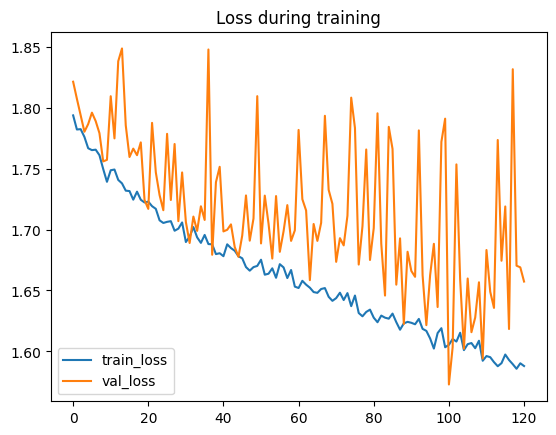

In [17]:
import matplotlib.pyplot as plt

plt.title("Loss during training")
plt.plot(history_efficient.history['loss'], label='train_loss')
plt.plot(history_efficient.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


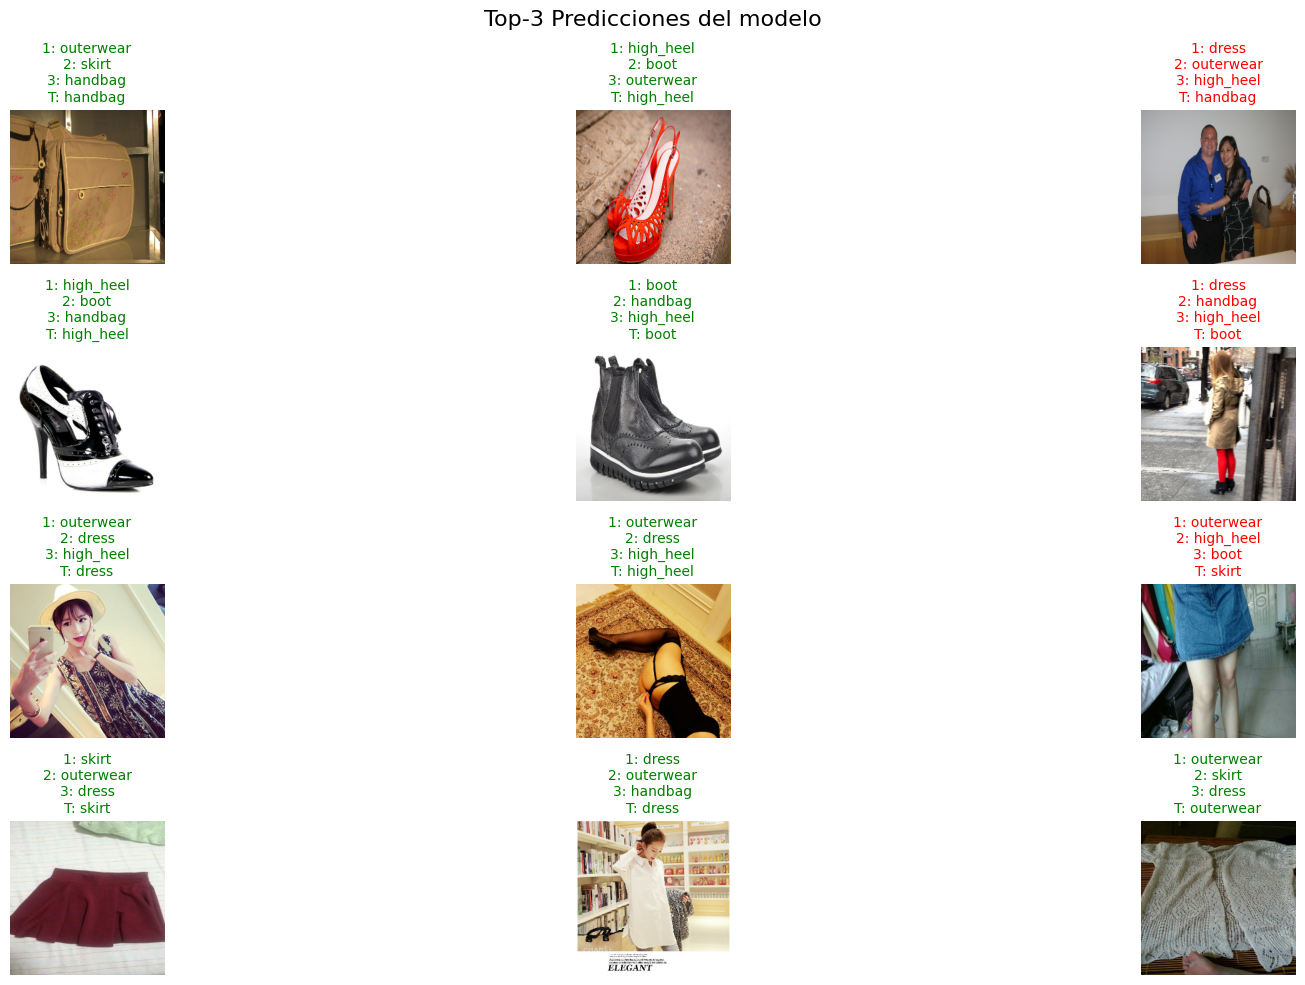

In [18]:
plot_top3_predictions(model_effnet, val_ds, id2label, rows=4, cols=3)

In [ ]:
2